In [9]:
import mne
import pandas as pd
import numpy as np
import os
from datetime import datetime, timezone, timedelta

# --- Configuration ---
# Make paths relative to WORKSPACE_ROOT

# Determine paths programmatically instead of hardcoding
WORKSPACE_ROOT = os.getcwd()

# Define experiment details
SAMPLE_DATA_FOLDER = "sample_data"
EXPERIMENT_ID = "E23B6B24FX14_1743611361000"

# Construct file paths
edf_file_path = os.path.join(WORKSPACE_ROOT, SAMPLE_DATA_FOLDER, EXPERIMENT_ID, f"{EXPERIMENT_ID}.edf")
csv_file_path = os.path.join(WORKSPACE_ROOT, SAMPLE_DATA_FOLDER, EXPERIMENT_ID, f"{EXPERIMENT_ID}.csv")

# Print workspace root for verification
print(f"Using workspace root: {WORKSPACE_ROOT}")

FS_ORIGINAL = 0 

# --- Load Sleep stages (only the 'Sleep stage' column is needed now) ---
print(f"Loading sleep stages from: {csv_file_path}")
stages_df = pd.read_csv(csv_file_path, usecols=['Sleep stage'])

# --- Load EDF Data ---
print(f"Loading EDF data from: {edf_file_path}")
raw = mne.io.read_raw_edf(edf_file_path, preload=True, verbose='INFO')
FS_ORIGINAL = int(raw.info['sfreq'])

# session_start_time_utc is still useful for metadata, even if not for stage alignment
if raw.info['meas_date']:
    session_start_time_utc = raw.info['meas_date'] 
else:
    try:
        filename = os.path.basename(edf_file_path)
        timestamp_ms = int(filename.split('_')[1])
        session_start_time_utc = datetime.fromtimestamp(timestamp_ms / 1000, timezone.utc) 
        print(f"Inferred session start time from filename: {session_start_time_utc}")
    except Exception as e:
        print(f"Could not infer session start time from filename ({e}), setting to now (UTC).")
        session_start_time_utc = datetime.now(timezone.utc)

if session_start_time_utc.tzinfo is None:
    print("Warning: session_start_time_utc was naive, localizing to UTC.")
    session_start_time_utc = session_start_time_utc.replace(tzinfo=timezone.utc)
elif session_start_time_utc.tzinfo != timezone.utc:
    print(f"Warning: session_start_time_utc was {session_start_time_utc.tzinfo}, converting to UTC.")
    session_start_time_utc = session_start_time_utc.astimezone(timezone.utc)

print(f"Session start time (UTC): {session_start_time_utc}")
print(f"Original sampling frequency: {FS_ORIGINAL} Hz")

# --- Prepare EEG Data ---
EEG_CHANNELS_TO_USE = raw.ch_names
print(f"Using available EEG channels from EDF: {EEG_CHANNELS_TO_USE}")
raw_eeg = raw.copy().pick_channels(EEG_CHANNELS_TO_USE, ordered=False)
eeg_data = raw_eeg.get_data() 

# >>> Corrected placement and definition of session_start_time_utc_eeg <<<
session_start_time_utc_eeg = raw_eeg.info['meas_date']
if session_start_time_utc_eeg.tzinfo is None:
    session_start_time_utc_eeg = session_start_time_utc_eeg.replace(tzinfo=timezone.utc)

print(f"EEG data loaded. Shape: {eeg_data.shape}, Sampling Rate: {FS_ORIGINAL} Hz")
print(f"EEG session start time (UTC): {session_start_time_utc_eeg.isoformat()}")

eog_data = None 
print("EOG data processing and derivation has been removed for this simulation.")

# --- Print final data shapes and info ---
print("Data loading and initial preparation complete.")
print(f"EEG data shape: {eeg_data.shape}")
print("EOG data: Not used in this simulation.")
print(f"Sampling Frequency (FS_ORIGINAL): {FS_ORIGINAL} Hz")

# --- Load Sleep stages Data ---
stages_df = pd.read_csv(csv_file_path, comment='#')
# Assuming the first column is 'Time' (ISO format or Unix timestamp) and the second is 'Sleep stage'
stages_df.columns = ['Timestamp', 'Sleep stage'] # Ensure correct column names

# Convert 'Time' to datetime objects and then to seconds from the EEG session start
def parse_time(time_val):
    if isinstance(time_val, str):
        return datetime.fromisoformat(time_val.replace("Z", "+00:00"))
    elif isinstance(time_val, (int, float)): # Assuming Unix timestamp if numeric
        return datetime.fromtimestamp(time_val, tz=timezone.utc)
    return None

stages_df['datetime_utc'] = stages_df['Timestamp'].apply(parse_time)
stages_df = stages_df.dropna(subset=['datetime_utc']) # Remove rows where time parsing failed
stages_df = stages_df.sort_values(by='datetime_utc') # Ensure chronological order

# Use EEG start time as the reference for sleep stage timings
session_start_time_utc_stages = stages_df['datetime_utc'].min()
# Align stages_df 'seconds_from_session_start' with the EEG data's session_start_time_utc_eeg
stages_df['seconds_from_session_start'] = (stages_df['datetime_utc'] - session_start_time_utc_eeg).dt.total_seconds()

# Ensure 'seconds_from_session_start' are non-negative (stages can't start before EEG)
stages_df = stages_df[stages_df['seconds_from_session_start'] >= 0]


print(f"Sleep stages loaded. Number of entries: {len(stages_df)}")
if not stages_df.empty:
    print(f"First sleep stage entry: Time {stages_df.iloc[0]['datetime_utc'].isoformat()}, Stage {stages_df.iloc[0]['Sleep stage']}, Seconds from EEG start: {stages_df.iloc[0]['seconds_from_session_start']:.2f}")
    print(f"Last sleep stage entry: Time {stages_df.iloc[-1]['datetime_utc'].isoformat()}, Stage {stages_df.iloc[-1]['Sleep stage']}, Seconds from EEG start: {stages_df.iloc[-1]['seconds_from_session_start']:.2f}")
else:
    print("Warning: Sleep stages DataFrame is empty after processing.")

# Set the overall session start time for the simulation to be the EEG start time.
session_start_time_utc = session_start_time_utc_eeg
print(f"Simulation session start time (UTC) set to EEG start: {session_start_time_utc.isoformat()}")

# Simulation duration based on EEG data length
total_samples_eeg = eeg_data.shape[1]
simulation_duration_seconds = total_samples_eeg / FS_ORIGINAL
print(f"Total EEG samples: {total_samples_eeg}, Simulation duration: {simulation_duration_seconds:.2f} seconds")

# EOG data loading and processing is removed as per user request.
eog_data = None
fs_eog = None
print("EOG data processing has been skipped.")

# Ensure stages_df is available for the next cells
print(f"Stages DF head:\\n{stages_df.head()}")

# --- Load EEG Data ---
raw_eeg = mne.io.read_raw_edf(edf_file_path, preload=True, verbose=False)
# Or adjust channel names
eeg_data = raw_eeg.get_data(picks=['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ'])
fs_original = int(raw_eeg.info['sfreq'])
session_start_time_utc_eeg = raw_eeg.info['meas_date']
if session_start_time_utc_eeg.tzinfo is None:
    session_start_time_utc_eeg = session_start_time_utc_eeg.replace(tzinfo=timezone.utc)

print(f"EEG data loaded. Shape: {eeg_data.shape}, Sampling Rate: {fs_original} Hz")
print(f"EEG session start time (UTC): {session_start_time_utc_eeg.isoformat()}")

# --- Load Sleep stages Data & Generate Timestamps ---
# Load only the 'Sleep stage' column, or if 'Time' is needed for other reasons, load it but don't use for primary timing.
try:
    # Attempt to read, expecting at least 'Sleep stage'. If 'Time' exists, it's fine.
    stages_df_raw = pd.read_csv(csv_file_path, comment='#')
    if 'Sleep stage' not in stages_df_raw.columns:
        # If 'Sleep stage' is not a header, assume it's the second column (index 1)
        # and the first column (index 0) might be original times (which we will ignore for timing)
        stages_df_raw = pd.read_csv(csv_file_path, comment='#', header=None)
        # Try to infer sensible column names if no header
        if stages_df_raw.shape[1] > 1:
            stages_df_raw.columns = [f'Column{i}' for i in range(stages_df_raw.shape[1])]
            # Assume the relevant stage data is in a column named 'Sleep stage' or likely the second one
            # This part might need adjustment based on actual CSV structure without headers
            if 'Sleep stage' in stages_df_raw.columns:
                stages_df = pd.DataFrame(stages_df_raw['Sleep stage'])
            elif stages_df_raw.shape[1] >= 2: # Take second column as sleep stage
                stages_df = pd.DataFrame(stages_df_raw.iloc[:, 1])
                stages_df.columns = ['Sleep stage']
            else: # Single column CSV, assume it's sleep stages
                stages_df = pd.DataFrame(stages_df_raw.iloc[:, 0])
                stages_df.columns = ['Sleep stage']
        else: # Single column CSV
            stages_df = pd.DataFrame(stages_df_raw.iloc[:, 0])
            stages_df.columns = ['Sleep stage']
    else:
        stages_df = pd.DataFrame(stages_df_raw['Sleep stage'])
except Exception as e:
    print(f"Error reading or processing CSV: {e}. Please check CSV format.")
    stages_df = pd.DataFrame(columns=['Sleep stage']) # Create empty df to avoid downstream errors

stages_df = stages_df[stages_df['Sleep stage'] != 'UNKNOWN'] # Filter out UNKNOWN stages
stages_df = stages_df.reset_index(drop=True) # Ensure clean index

# Generate datetime_utc and seconds_from_session_start assuming 30s intervals
num_stages = len(stages_df)
stage_datetimes_utc = [session_start_time_utc_eeg + timedelta(seconds=i * 30) for i in range(num_stages)]
stages_df['datetime_utc'] = stage_datetimes_utc
stages_df['seconds_from_session_start'] = np.arange(0, num_stages * 30, 30)

print(f"Sleep stages processed. Number of entries: {len(stages_df)}")
if not stages_df.empty:
    print(f"First generated sleep stage entry: Time {stages_df.iloc[0]['datetime_utc'].isoformat()}, Stage {stages_df.iloc[0]['Sleep stage']}, Seconds from EEG start: {stages_df.iloc[0]['seconds_from_session_start']:.2f}")
    print(f"Last generated sleep stage entry: Time {stages_df.iloc[-1]['datetime_utc'].isoformat()}, Stage {stages_df.iloc[-1]['Sleep stage']}, Seconds from EEG start: {stages_df.iloc[-1]['seconds_from_session_start']:.2f}")
else:
    print("Warning: Sleep stages DataFrame is empty after processing.")

# Set the overall session start time for the simulation to be the EEG start time.
session_start_time_utc = session_start_time_utc_eeg
print(f"Simulation session start time (UTC) set to EEG start: {session_start_time_utc.isoformat()}")

# Simulation duration based on EEG data length
total_samples_eeg = eeg_data.shape[1]
simulation_duration_seconds = total_samples_eeg / fs_original
print(f"Total EEG samples: {total_samples_eeg}, Simulation duration: {simulation_duration_seconds:.2f} seconds")

# EOG data loading and processing is removed.
eog_data = None
fs_eog = None
print("EOG data processing has been skipped.")

print(f"Stages DF head:\\n{stages_df.head()}")

Using workspace root: /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core
Loading sleep stages from: /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/sample_data/E23B6B24FX14_1743611361000/E23B6B24FX14_1743611361000.csv
Loading EDF data from: /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/sample_data/E23B6B24FX14_1743611361000/E23B6B24FX14_1743611361000.edf
Extracting EDF parameters from /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/sample_data/E23B6B24FX14_1743611361000/E23B6B24FX14_1743611361000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3014374  =      0.000 ... 24114.992 secs...
Session start time (UTC): 2025-04-02 23:29:20+00:00
Original sampling frequency: 125 Hz
Using available EEG channels from EDF: ['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']
NOTE: pick_channels() is a

In [10]:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import scipy.signal
import sys # Added sys import
import os # Added os import

# Add workspace root to sys.path

if WORKSPACE_ROOT not in sys.path:
    sys.path.insert(0, WORKSPACE_ROOT)

from dl_alertness_detection import predict_alertness_ema # Import actual function
from app.main import needed_len # Import needed_len

# --- Simulation Constants ---
FS_TARGET = 125  # Hz, target sampling frequency for processing
REM_SLEEP_STAGE_VALUE = 3
MAX_SUCCESSIVE_REM_CUES = 2
REM_AUDIO_CUE_INTERVAL_SECONDS = 10  # Minimum interval between REM cue sequences
ALERTNESS_THRESHOLD_FOR_ACTION = 0.6 # Example threshold
ALERTNESS_EMA_ALPHA = 0.1 # For smoothing alertness, if we implement EMA here. The imported function has its own.
SECONDS_PER_WINDOW = 1 # Process data second by second

# --- Helper Functions ---
def get_sleep_stage_at_time(current_sim_time_seconds, stages_df_param): 
    """ 
    Determines the sleep stage for the current_simulation_time_seconds.
    Assumes stages_df_param has rows corresponding to 30-second epochs,
    starting from t=0 of the simulation.
    current_sim_time_seconds is relative to the start of the simulation (0 to simulation_duration_seconds)
    """
    if stages_df_param.empty:
        return "UNKNOWN"

    stage_index = int(current_sim_time_seconds // 30)
    sim_total_stages_count = len(stages_df_param) # Derive count internally

    if 0 <= stage_index < sim_total_stages_count:
        return stages_df_param['Sleep stage'].iloc[stage_index] # Assuming 'Sleep stage' is correct based on user's fix
    elif stage_index >= sim_total_stages_count and sim_total_stages_count > 0:
        # If current time exceeds the duration covered by stages, return the last known stage
        return stages_df_param['Sleep stage'].iloc[-1] 
    else: # stage_index < 0 or sim_total_stages_count is 0
        return "UNKNOWN"

print(f"Constants and helper functions defined. needed_len: {needed_len}")

Constants and helper functions defined. needed_len: 18750


In [11]:
sim_metadata_audio_cue_timestamps = []
last_audio_cue_time = -float('inf')

def fire_rem_audio_cues_sequence_sim(current_time_seconds):
    """Simulates firing audio cues and records their timestamps."""
    global last_audio_cue_time, sim_metadata_audio_cue_timestamps
    
    print(f"SIM AUDIO: Attempting to fire REM audio cue sequence at {current_time_seconds:.2f}s")
    for i in range(MAX_SUCCESSIVE_REM_CUES):
        cue_initiation_time = current_time_seconds + (i * REM_AUDIO_CUE_INTERVAL_SECONDS)
        # Check if enough time has passed since the *very last* cue of any sequence
        # This is a simplified check for simulation; real app might have more complex state
        if cue_initiation_time < last_audio_cue_time + REM_AUDIO_CUE_INTERVAL_SECONDS: 
            # This check is mostly to prevent overlapping print statements in rapid succession if called improperly
            # The main loop's `is_in_rem_cycle` and `rem_audio_cues_fired_this_cycle` should prevent re-triggering too soon.
            print(f"SIM AUDIO: Cue {i+1} at {cue_initiation_time:.2f}s would be too soon. Skipping.")
            continue

        sim_metadata_audio_cue_timestamps.append(cue_initiation_time)
        print(f"SIM AUDIO: Cue {i+1}/{MAX_SUCCESSIVE_REM_CUES} scheduled/fired at {cue_initiation_time:.2f}s (Simulated)")
        last_audio_cue_time = cue_initiation_time
        
        # In a real simulation, you might want to simulate the time passing for the cue duration
        # For this, we just record the timestamp of when it *would* play.
    return True # Indicates sequence was initiated

print("Simulated audio cue function defined.")

Simulated audio cue function defined.


In [ ]:
from scipy.signal import resample_poly
import math 
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta
import scipy.signal
import time # Added time import for verbosity

# This cell should be run after the previous cells defining constants, helpers, and importing predict_alertness_ema

def real_time_processing_simulation(
    eeg_data_original, 
    fs_original, 
    fs_target, 
    stages_df_sim, 
    simulation_duration_seconds_sim, 
    session_start_iso_sim, # This is the correct parameter name
    sim_total_stages_count, # Total number of stage entries
):
    """
    Simulates the real-time processing loop using pre-recorded data.
    Uses actual alertness detection model.
    """
    print(f"Simulation starting with duration: {simulation_duration_seconds_sim}s, Target FS: {fs_target}Hz")

    # Ensure eeg_data_original is 2D (channels, samples) and select the first channel if multiple
    if eeg_data_original.ndim == 1:
        eeg_data_original = eeg_data_original.reshape(1, -1) # Make it (1, samples)
    
    # For the current DeepSleepNet model, it expects single channel EEG data.
    # If eeg_channels_to_use_sim has more than one, we should select one or average.
    # For now, assuming the loaded eeg_data corresponds to the single channel expected by the model.
    # If eeg_data_original has multiple channels, let's pick the first one specified in eeg_channels_to_use_sim
    # This logic assumes eeg_data_original was loaded considering eeg_channels_to_use_sim from cell 1
    # For simplicity, if eeg_data_original still has multiple channels here, we take the first one.
    if eeg_data_original.shape[0] > 1:
        print(f"Warning: Original EEG data has {eeg_data_original.shape[0]} channels. Using the first channel for alertness prediction.")
        eeg_single_channel_original = eeg_data_original[0, :]
    else:
        eeg_single_channel_original = eeg_data_original.squeeze() # Ensure it's 1D

    # Resample the selected EEG channel data
    num_original_samples = len(eeg_single_channel_original)
    num_target_samples = int(num_original_samples * fs_target / fs_original)
    eeg_resampled = scipy.signal.resample(eeg_single_channel_original, num_target_samples)
    print(f"EEG data resampled from {num_original_samples} to {num_target_samples} samples.")

    # Simulation loop variables
    sim_timestamps = []
    sim_sleep_stages = []
    sim_alertness_scores = []
    
    # Declare global and clear before use in this function
    global sim_metadata_audio_cue_timestamps
    # sim_metadata_audio_cue_timestamps is already global from cell ffbe0495, clear it for new run
    # Ensure it exists in global scope if this cell is run independently of cell ffbe0495 for some reason
    if 'sim_metadata_audio_cue_timestamps' not in globals():
        sim_metadata_audio_cue_timestamps = [] 
    else:
        sim_metadata_audio_cue_timestamps.clear()

    last_rem_audio_cue_time = -float('inf')
    successive_rem_cues_fired = 0
    current_alertness_ema_sim = 0.5 # Initial value

    # Buffer for EEG data for alertness model (needs `needed_len` samples)
    eeg_buffer_alertness = np.zeros(needed_len) # Initialize with zeros
    
    total_windows = int(simulation_duration_seconds_sim // SECONDS_PER_WINDOW)
    print(f"Total windows to process: {total_windows}")

    for i in range(total_windows):
        current_sim_time_seconds = i * SECONDS_PER_WINDOW
        # print(f"Simulating time: {current_sim_time_seconds:.2f}s") # Verbose

        # 1. Get current sleep stage
        current_sleep_stage = get_sleep_stage_at_time(
            current_sim_time_seconds, 
            stages_df_sim
        )

        # 2. Get EEG data for the current window (1 second)
        start_sample_idx = int(current_sim_time_seconds * fs_target)
        end_sample_idx = start_sample_idx + int(SECONDS_PER_WINDOW * fs_target)
        
        if end_sample_idx > len(eeg_resampled):
            print(f"Reached end of resampled EEG data at {current_sim_time_seconds}s. Stopping simulation.")
            break
        
        current_eeg_window = eeg_resampled[start_sample_idx:end_sample_idx]

        # 3. Update EEG buffer for alertness model
        # Shift buffer and add new data
        eeg_buffer_alertness = np.roll(eeg_buffer_alertness, -len(current_eeg_window))
        eeg_buffer_alertness[-len(current_eeg_window):] = current_eeg_window

        # 4. Predict alertness (if buffer has enough data)
        # The model expects `needed_len` samples. We feed it every second.
        # The `predict_alertness_ema` function itself handles chunking internally based on its own `input_len` and `seq_len`.
        if i * SECONDS_PER_WINDOW * fs_target >= needed_len: # Ensure we have at least needed_len of data processed into buffer
            # The function expects the raw segment of `needed_len`
            # The current eeg_buffer_alertness *is* that segment.
            current_alertness_ema_sim = 1 - predict_alertness_ema(eeg_buffer_alertness, ema_span=20) # ema_span is internal to func
        else:
            # Not enough data yet for a full prediction, use initial/previous or a placeholder
            current_alertness_ema_sim = 0.5 # Or some other strategy
            # print(f"Not enough data for alertness prediction yet. Current buffer filled: {i * SECONDS_PER_WINDOW * fs_target / needed_len * 100:.1f}%")

        # 5. REM Detection and Audio Cue Logic (Simplified)
        is_rem_sleep = (current_sleep_stage == REM_SLEEP_STAGE_VALUE)
        
        if is_rem_sleep:
            print(f"REM detected at {current_sim_time_seconds:.2f}s. Alertness: {current_alertness_ema_sim:.2f}")
            can_fire_due_to_interval = (current_sim_time_seconds - last_rem_audio_cue_time) >= REM_AUDIO_CUE_INTERVAL_SECONDS
            can_fire_due_to_successive_limit = successive_rem_cues_fired < MAX_SUCCESSIVE_REM_CUES
            
            if can_fire_due_to_interval and can_fire_due_to_successive_limit:
                print(f"  Firing REM audio cue sequence at {current_sim_time_seconds:.2f}s. Successive count: {successive_rem_cues_fired + 1}")
                fire_rem_audio_cues_sequence_sim(current_sim_time_seconds) # Records to global list
                last_rem_audio_cue_time = current_sim_time_seconds 
                successive_rem_cues_fired += 1
            elif not can_fire_due_to_interval:
                # print(f"  REM cue suppressed: Interval not met. Last cue at {last_rem_audio_cue_time:.2f}s")
                pass # Interval not met
            elif not can_fire_due_to_successive_limit:
                # print(f"  REM cue suppressed: Max successive cues reached.")
                pass # Max successive cues reached
        else:
            # Not in REM, reset successive cue counter
            if successive_rem_cues_fired > 0:
                # print(f"Exited REM or not in REM. Resetting successive REM cue counter from {successive_rem_cues_fired}.")
                pass
            successive_rem_cues_fired = 0
            
        # Store metadata for this second
        sim_timestamps.append(current_sim_time_seconds)
        sim_sleep_stages.append(current_sleep_stage)
        sim_alertness_scores.append(current_alertness_ema_sim)

        # if (i + 1) % (10 * SECONDS_PER_WINDOW) == 0: # Print progress every 10 seconds of simulation
        #     print(f"Progress: {current_sim_time_seconds:.0f}s / {simulation_duration_seconds_sim:.0f}s. Stage: {current_sleep_stage}, Alertness: {current_alertness_ema_sim:.3f}")

    print("Simulation loop finished.")
    
    # Prepare results
    results = {
        "timestamps": np.array(sim_timestamps),
        "sleep_stages": np.array(sim_sleep_stages),
        "alertness_scores": np.array(sim_alertness_scores),
        "audio_cue_timestamps": np.array(sim_metadata_audio_cue_timestamps),
        "fs_target": fs_target,
        "simulation_duration_seconds": simulation_duration_seconds_sim,
        "session_start_iso": session_start_iso_sim,
        "sleep_stage_interval_simulated": 30, # Fixed interval in seconds
    }
    return results

print("Simulation loop function `real_time_processing_simulation` defined and ready.")

Simulation loop function `real_time_processing_simulation` defined and ready.


In [13]:
# --- Execute the Simulation ---
# This cell assumes all previous cells (data loading, helpers, simulation function) have been run.

print("Starting simulation execution...")

# Ensure global list for audio cues is initialized if not already by cell ffbe0495
if 'sim_metadata_audio_cue_timestamps' not in globals():
    sim_metadata_audio_cue_timestamps = []
else:
    sim_metadata_audio_cue_timestamps.clear() # Clear for a fresh run

# Call the simulation function with variables loaded/defined in previous cells
# These variables should be in the global notebook scope from executing Cell 1 (b00d3c33) and Cell 2 (921c860b)
sim_results = real_time_processing_simulation(
    eeg_data,                   # Loaded in Cell 1 (b00d3c33)
    FS_ORIGINAL,                # Defined in Cell 1 (b00d3c33)
    FS_TARGET,                  # Defined in Cell 2 (921c860b)
    stages_df,                  # Loaded in Cell 1 (b00d3c33)
    simulation_duration_seconds,# Calculated in Cell 1 (b00d3c33)
    session_start_time_utc.isoformat(), # Corrected: Convert datetime object to ISO string
    EEG_CHANNELS_TO_USE         # Defined in Cell 1 (b00d3c33)
)

print("Simulation finished. Results dictionary created.")
print(f"Number of audio cues triggered: {len(sim_results['audio_cue_timestamps'])}")
print(f"First few alertness scores: {sim_results['alertness_scores'][:10]}")
print(f"Simulated sleep stage interval: {sim_results['sleep_stage_interval_simulated']}")

Starting simulation execution...
Simulation starting with duration: 24115.0s, Target FS: 125Hz
EEG data resampled from 3014375 to 3014375 samples.
Total windows to process: 24115
Simulation loop finished.
Simulation finished. Results dictionary created.
Number of audio cues triggered: 0
First few alertness scores: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Simulated sleep stage interval: 30


In [14]:
# --- Save Simulation Results ---
import numpy as np
import os

output_filename = "simulation_results.npz"
output_path = os.path.join(WORKSPACE_ROOT, output_filename) # Save in workspace root

if 'sim_results' in globals():
    try:
        np.savez_compressed(output_path, **sim_results)
        print(f"Simulation results successfully saved to: {output_path}")
    except Exception as e:
        print(f"Error saving simulation results: {e}")
else:
    print("'sim_results' not found. Please run the simulation cell first.")

Simulation results successfully saved to: /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/simulation_results.npz


Loaded data keys: ['timestamps', 'sleep_stages', 'alertness_scores', 'audio_cue_timestamps', 'fs_target', 'simulation_duration_seconds', 'session_start_iso', 'sleep_stage_interval_simulated']
Unique sleep stages found in loaded data: ['Deep' 'Light' 'REM' 'Wake']
Sample of first 20 mapped_sleep_stages_for_plot: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Number of NaN values in mapped_sleep_stages_for_plot: 0 out of 24115


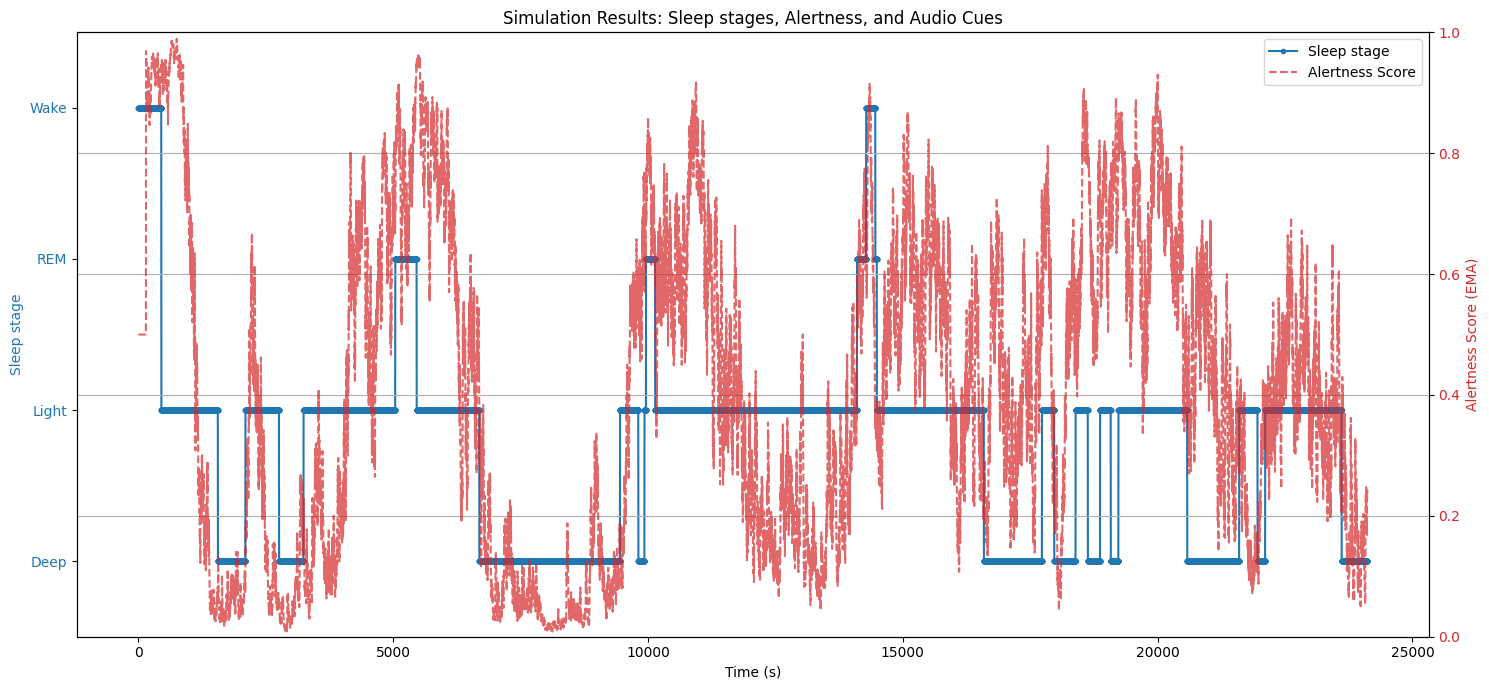

In [15]:
# --- Plot Simulation Results ---
import numpy as np
import matplotlib.pyplot as plt
import os

# Assuming WORKSPACE_ROOT is defined (e.g., from cell 921c860b or defined here again)
if 'WORKSPACE_ROOT' not in globals():
    WORKSPACE_ROOT = '/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core'

results_filename = "simulation_results.npz"
results_path = os.path.join(WORKSPACE_ROOT, results_filename)

if not os.path.exists(results_path):
    print(f"Results file not found at {results_path}. Please run the saving cell first.")
else:
    try:
        data = np.load(results_path, allow_pickle=True)
        print("Loaded data keys:", list(data.keys()))

        timestamps = data['timestamps']
        sleep_stages_from_file = data['sleep_stages'] # This contains strings like 'Wake', 'REM'
        alertness_scores = data['alertness_scores']
        audio_cue_timestamps = data['audio_cue_timestamps']
        
        # --- Debug: Print unique stages from the loaded data ---
        unique_stages_in_data = np.unique(sleep_stages_from_file)
        print(f"Unique sleep stages found in loaded data: {unique_stages_in_data}")
        # --- End Debug ---

        # Define the mapping from stage strings to desired y-axis categories and plot values
        # Y-axis categories and their desired order (top to bottom on plot)
        # Wake (plot y=3), REM (plot y=2), Light (plot y=1), Deep (plot y=0)
        y_plot_values_map = {
            'Wake': 3,
            'REM': 2,
            'Light': 1, # Assuming 'Light' covers N1/N2
            'Deep': 0   # Assuming 'Deep' covers N3
            # Add other string mappings if present, e.g., 'N1', 'N2', 'N3' directly
        }

        mapped_sleep_stages_for_plot = []
        for stage_str in sleep_stages_from_file:
            if stage_str in y_plot_values_map:
                mapped_sleep_stages_for_plot.append(y_plot_values_map[stage_str])
            # Handle cases where stage strings might be slightly different (e.g., case sensitivity, or specific N1/N2/N3)
            # Example: if your data has "N1" or "N2" for light sleep:
            # elif stage_str == "N1" or stage_str == "N2":
            #     mapped_sleep_stages_for_plot.append(y_plot_values_map['Light'])
            else:
                print(f"Warning: Unmapped stage string '{stage_str}' found. Will be plotted as NaN.")
                mapped_sleep_stages_for_plot.append(np.nan) # Stage string not in our defined map
        
        # --- Debug: Print a sample of mapped stages ---
        sample_mapped_stages = mapped_sleep_stages_for_plot[:20] # Print first 20 mapped values
        num_nan_stages = np.sum(np.isnan(mapped_sleep_stages_for_plot))
        print(f"Sample of first 20 mapped_sleep_stages_for_plot: {sample_mapped_stages}")
        print(f"Number of NaN values in mapped_sleep_stages_for_plot: {num_nan_stages} out of {len(mapped_sleep_stages_for_plot)}")
        # --- End Debug ---

        fig, ax1 = plt.subplots(figsize=(15, 7))

        color = 'tab:blue'
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Sleep stage', color=color)
        if not np.all(np.isnan(mapped_sleep_stages_for_plot)):
            ax1.plot(timestamps, mapped_sleep_stages_for_plot, color=color, linestyle='-', marker='.', label='Sleep stage')
        else:
            print("WARNING: All mapped sleep stages are NaN. Sleep stage line will not be plotted.")
        ax1.tick_params(axis='y', labelcolor=color)
        
        # Set y-ticks and labels according to the keys in y_plot_values_map, ordered as desired
        # The y_plot_values_map already defines the labels for the numeric y values.
        # We want the labels on the y-axis to be 'Wake', 'REM', 'Light', 'Deep' from top to bottom.
        # So, ticks should be [3, 2, 1, 0] and labels ['Wake', 'REM', 'Light', 'Deep']
        sorted_y_labels = sorted(y_plot_values_map.items(), key=lambda item: item[1], reverse=True)
        y_ticks = [item[1] for item in sorted_y_labels]
        y_tick_labels = [item[0] for item in sorted_y_labels]

        ax1.set_yticks(y_ticks)
        ax1.set_yticklabels(y_tick_labels)
        ax1.set_ylim(min(y_ticks) - 0.5, max(y_ticks) + 0.5) # Adjust ylim to give some padding

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Alertness Score (EMA)', color=color)
        ax2.plot(timestamps, alertness_scores, color=color, linestyle='--', label='Alertness Score', alpha=0.7)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(0, 1)

        if len(audio_cue_timestamps) > 0:
            for cue_time in audio_cue_timestamps:
                ax1.axvline(x=cue_time, color='tab:green', linestyle=':', linewidth=2, label='Audio Cue (REM)' if 'Audio Cue (REM)' not in [l.get_label() for l in ax1.lines] else "")
        
        plt.title('Simulation Results: Sleep stages, Alertness, and Audio Cues')
        fig.tight_layout()
        
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        if len(audio_cue_timestamps) > 0 and not any('Audio Cue (REM)' in l for l in labels + labels2):
            from matplotlib.lines import Line2D
            proxy_line = Line2D([0], [0], linestyle=':', color='tab:green', linewidth=2, label='Audio Cue (REM)')
            lines.append(proxy_line)
            labels.append('Audio Cue (REM)')

        ax2.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Error plotting results: {e}")
        import traceback
        traceback.print_exc()